# Scikit Learn's PCA and GMM
This notebook will be used to check the sanity of the algorithms implemented in stl10_pca_gmm_experiment jupyter notebook.

## Importing Modules

In [1]:
from numpy.random import default_rng
from pathlib import Path
from PIL import Image
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torchvision import datasets

import gc
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

rng = default_rng()

%matplotlib inline

## Data Preparation

In [2]:
def flatten_images(data):
    """
    Flatten stack of images to create a column vectors of data.

    Parameters
    ----------
    data : numpy.ndarray
        Numpy array of data.
        Images stacked on the 0th axis.
        data.shape = (num_images, res_y, res_x)

    Returns
    -------
    numpy.ndarray
        Flattened images. Each images is reshaped
        in to a column vector and are stacked along
        the 1st axis.
        shape = (num_pixels_per_image, num_images)
    """
    data_len = len(data)
    return data.reshape((data_len, -1)).T


def to_column_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[:, None]


def to_row_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[None, :]


def normalize(data):
    """
    Normalizes the given data.

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)

    Returns
    -------
    numpy.ndarray
        Returns the normalized data.
    float
        Returns the mean per feature.
    float
        Returns the standard deviation per feature.
    """
    data_mean = np.mean(data, axis=1, keepdims=True)
    data_std = np.std(data, axis=1, keepdims=True)

    return (data - data_mean) / data_std, data_mean, data_std


def denormalize(data, mean, std):
    """
    Denormalizes a give data

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)
    mean : float
        The mean per feature.
        shape = (num_features, 1)
    std : float
        The standard deviation per feature.
        shape = (num_features, 1)

    Returns
    -------
    numpy.ndarray
        Returns the denormalized data.
    """
    return data * std + mean

### Data Loading

In [3]:
ds_unlabeled = datasets.STL10(root="./data", split="unlabeled", download=True)
classes = ds_unlabeled.classes
print(f"STL10 unlabeled split size: {len(ds_unlabeled)}")

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
STL10 unlabeled split size: 100000


In [4]:
ds_test = datasets.STL10(root="./data", split="test")
print(f"STL10 test split size: {len(ds_test)}")

STL10 test split size: 8000


In [5]:
ds_train = datasets.STL10(root="./data", split="train")
print(f"STL10 train split size: {len(ds_train)}")

STL10 train split size: 5000


In [6]:
DATASET_UNLABELED_SIZE = 10_000
IMAGE_RESOLUTION = ds_unlabeled.data.shape[2:]
RESIZE_RESOLUTION = (72, 72)

In [7]:
data_unlabeled_RGB = rng.choice(
    ds_unlabeled.data, size=DATASET_UNLABELED_SIZE, replace=False
)

data_unlabeled = np.empty((DATASET_UNLABELED_SIZE, *IMAGE_RESOLUTION))

for idx, image in enumerate(data_unlabeled_RGB):
    data_unlabeled[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_unlabeled_flattened = flatten_images(data_unlabeled)

In [8]:
data_test = np.empty((len(ds_test), *IMAGE_RESOLUTION))

for idx, image in enumerate(ds_test.data):
    data_test[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_test_flattened = flatten_images(data_test)
data_test_labels = ds_test.labels

In [9]:
data_train = np.empty((len(ds_train), *IMAGE_RESOLUTION))

for idx, image in enumerate(ds_train.data):
    data_train[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_train_flattened = flatten_images(data_train)
data_train_labels = ds_train.labels

In [10]:
del ds_unlabeled, ds_train, ds_test, data_unlabeled, data_unlabeled_RGB, data_train, data_test
gc.collect()

170

### Plotting Function

In [11]:
def plot_sample(data, indices, title, shape = None):
    """
    Plots the sampled images from data.

    Parameters
    ----------
    data : numpy.ndarray
        A stack of images stored in numpy array.
    indices: list[int]
        List of image indices that will be plotted.
    title: str
        Descriptive title of the figure.
    shape: tuple[int]
        New shape size of data.
    """
    figure = plt.figure()
    plt.suptitle(title, fontsize=12)
    num_images = len(indices)
    for count, idx in enumerate(indices, 1):
        figure.add_subplot(int(np.ceil(num_images/3)), 3, count)

        img = data[:, idx]
        if shape:
            img = img.reshape(shape)

        
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    # plt.tight_layout()

def plot_cluster_dist(clusters, n_clusters, title):
    """
    Plots clusters distribution

    Parameters
    ----------
    clusters : numpy.ndarray
        Array of cluster assignment.
        shape = (n_samples,)
    n_clusters : int
        Number of clusters
    title : str
        Plot title
    """
    plt.figure()
    labels, counts = np.unique(clusters, return_counts=True)
    plt.bar(labels, counts)
    plt.xticks(list(range(n_clusters)));
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.title(title)

## Principal Component Analysis

### Mean Squared Error

In [12]:
def compute_mse(data, data_reconstructed):
    return np.sum(np.square(data - data_reconstructed)) / data.size

In [13]:
def plot_mse(mse_per_dim, dims, title):
    plt.figure(figsize=(15, 7.5))
    plt.plot(dims, mse_per_dim, "o-")
    plt.grid(visible=True, which="both")
    plt.xlabel("Dimension of z")
    plt.ylabel("Mean Squared Error")
    plt.title(title)

### MSE vs Dims, Unlabeled 10k

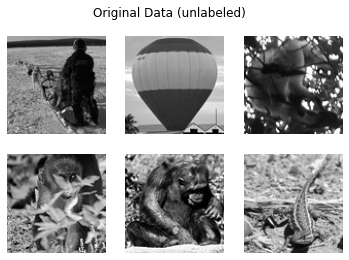

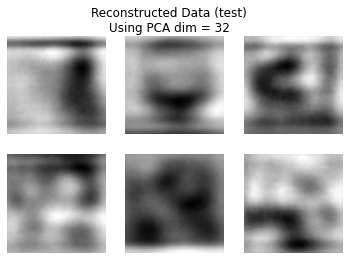

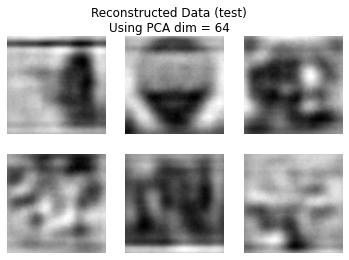

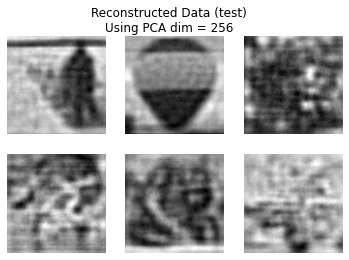

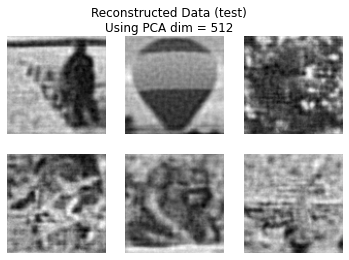

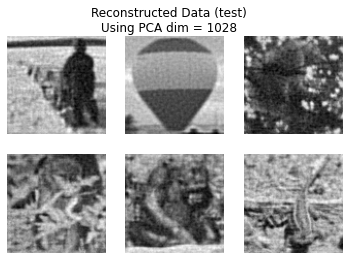

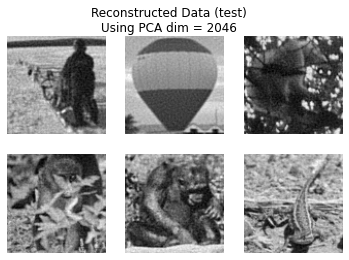

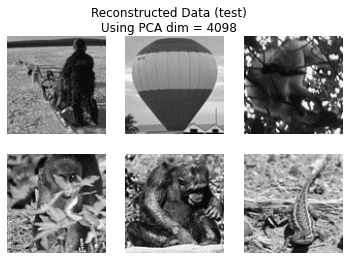

In [14]:
dims = [32, 64, 256, 512, 1028, 2046, 4098]

mse_per_dim = []

indices = list(range(6))
normalized_data_unlabeled_flatten, mean, std = normalize(data_unlabeled_flattened.T)
plot_sample(data_unlabeled_flattened, indices, "Original Data (unlabeled)", (96, 96))

for dim in dims:
    pca = PCA(n_components=dim)
    code = pca.fit_transform(normalized_data_unlabeled_flatten)
    reconstructed_data = denormalize(pca.inverse_transform(code), mean, std)
    mse = compute_mse(normalized_data_unlabeled_flatten, reconstructed_data)
    mse_per_dim.append(mse)
    plot_sample(
        reconstructed_data.T,
        indices,
        f"Reconstructed Data (test)\nUsing PCA dim = {dim}",
        (96, 96),
    )

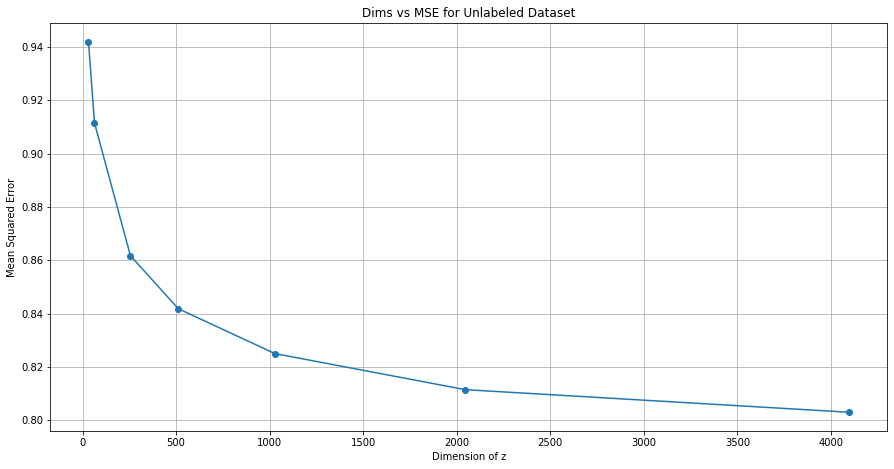

In [15]:
plot_mse(mse_per_dim, dims, "Dims vs MSE for Unlabeled Dataset")

### MSE vs Dims, Test

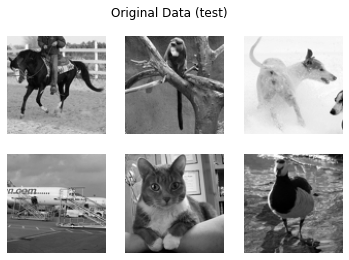

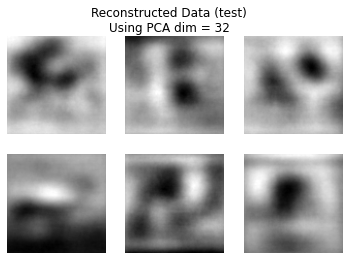

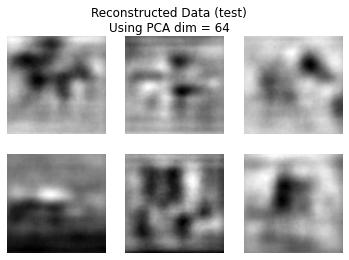

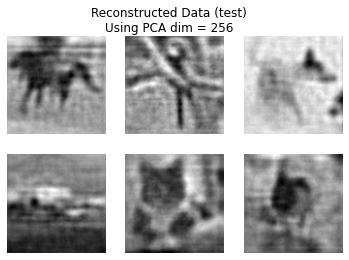

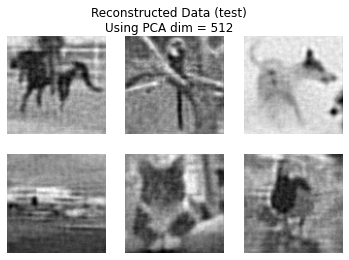

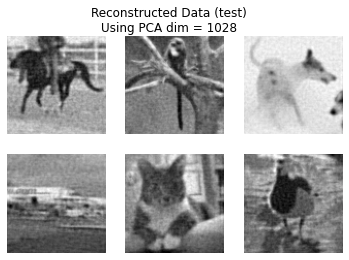

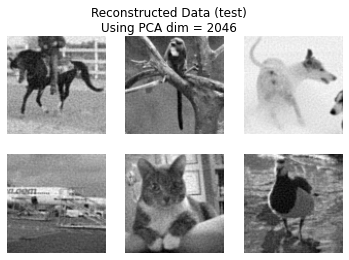

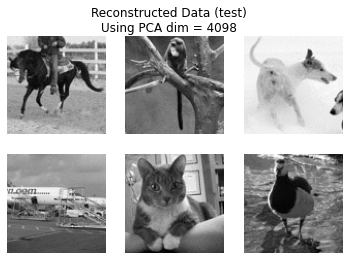

In [16]:
dims = [32, 64, 256, 512, 1028, 2046, 4098]

mse_per_dim = []

indices = list(range(6))
normalized_data_test_flatten, mean, std = normalize(data_test_flattened.T)
plot_sample(data_test_flattened, indices, "Original Data (test)", (96, 96))

for dim in dims:
    pca = PCA(n_components=dim)
    code = pca.fit_transform(normalized_data_test_flatten)
    reconstructed_data = denormalize(pca.inverse_transform(code), mean, std)
    mse = compute_mse(normalized_data_test_flatten, reconstructed_data)
    mse_per_dim.append(mse)
    plot_sample(
        reconstructed_data.T,
        indices,
        f"Reconstructed Data (test)\nUsing PCA dim = {dim}",
        (96, 96),
    )

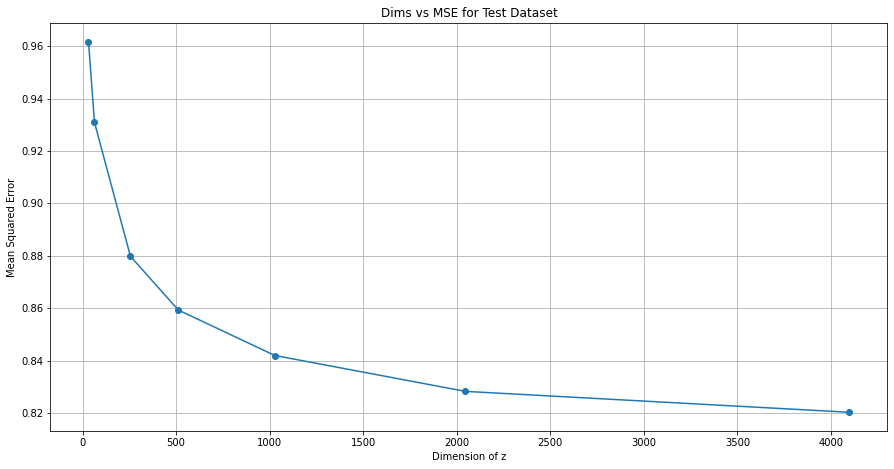

In [17]:
plot_mse(mse_per_dim, dims, "Dims vs MSE for Test Dataset")

### Optimal $z$-dim

In [18]:
dim_optimal = 128

normalized_data_unlabeled_flatten, mean_unlabeled, std_unlabeled = normalize(data_unlabeled_flattened)
pca_optimal = PCA(n_components=dim_optimal).fit(normalized_data_unlabeled_flatten.T)
code_optimal = pca_optimal.transform(normalized_data_unlabeled_flatten.T)

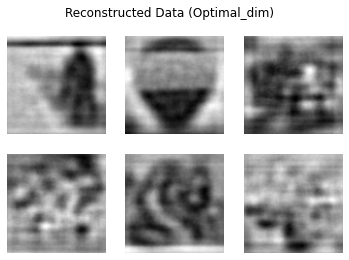

In [19]:
reconstructed_data = denormalize(pca_optimal.inverse_transform(code_optimal).T, mean_unlabeled, std_unlabeled).T
plot_sample(
    reconstructed_data.T,
    indices,
    f"Reconstructed Data (Optimal_dim)",
    (96, 96),
)

In [20]:
normalized_train, mean_train, std_train = normalize(data_train_flattened)
code_train = pca_optimal.transform(normalized_train.T)

In [21]:
normalized_test, mean_test, std_test = normalize(data_test_flattened)
code_test = pca_optimal.transform(normalized_test.T)

## Gaussian Model Mixture

### Build GMM

In [22]:
n_components = 10
gmm = GaussianMixture(n_components=n_components, verbose=2, verbose_interval=5).fit(code_optimal)

Initialization 0
  Iteration 5	 time lapse 3.97979s	 ll change 0.84183
  Iteration 10	 time lapse 2.51231s	 ll change 0.10652
  Iteration 15	 time lapse 2.45887s	 ll change 0.04704
  Iteration 20	 time lapse 2.47667s	 ll change 0.01547
  Iteration 25	 time lapse 2.47053s	 ll change 0.00962
  Iteration 30	 time lapse 2.51437s	 ll change 0.01347
  Iteration 35	 time lapse 2.46343s	 ll change 0.00232
  Iteration 40	 time lapse 2.54160s	 ll change 0.00178
  Iteration 45	 time lapse 2.52393s	 ll change 0.00860
  Iteration 50	 time lapse 2.44286s	 ll change 0.00285
  Iteration 55	 time lapse 2.45030s	 ll change 0.00141
Initialization converged: True	 time lapse 29.82049s	 ll -343.75945


### Cluster to Label Conversion

In [23]:
def add_label(y, cluster_name):
    num_labels = len(np.unique(y))
    max_corr_pred = -np.inf
    for assignment in it.permutations(range(num_labels)):
        assignment = np.array(assignment)
        corr_pred = np.count_nonzero(y==assignment[cluster_name])
        if corr_pred > max_corr_pred:
            cluster_to_label = assignment
            max_corr_pred = corr_pred
    
    return cluster_to_label, max_corr_pred


### Per Cluster Accuracy

In [24]:
def get_per_class_accuracy(y, y_pred):
    labels = np.unique(y)
    accuracies = np.empty(len(labels))
    for label in labels:
        label_idxs, = np.where(y == label)
        corr_pred = np.count_nonzero(y_pred[label_idxs] == label)
        accuracies[label] = corr_pred / len(label_idxs)

    return accuracies


### Labeling Clusters Using Train Data

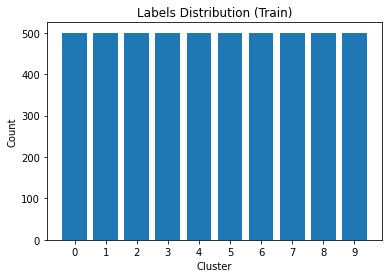

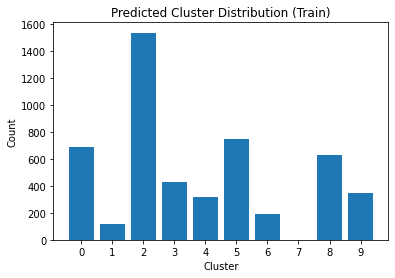

In [25]:
train_labels_predicted = gmm.predict(code_train)

plot_cluster_dist(data_train_labels, 10, "Labels Distribution (Train)")
plot_cluster_dist(train_labels_predicted, 10, "Predicted Cluster Distribution (Train)")

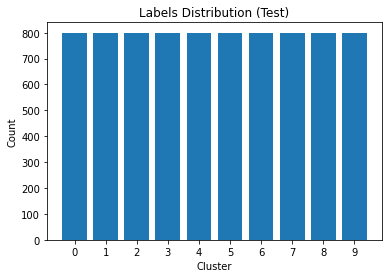

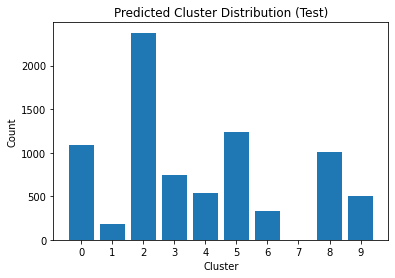

In [26]:
test_labels_predicted = gmm.predict(code_test)

plot_cluster_dist(data_test_labels, 10, "Labels Distribution (Test)")
plot_cluster_dist(test_labels_predicted, 10, "Predicted Cluster Distribution (Test)")

### Adding Labels to Clusters

In [27]:
cluster_to_label, corr_pred = add_label(data_train_labels, train_labels_predicted)
print(f"Accuracy (Train): {corr_pred/len(data_train_labels)*100:.2f}%")

Accuracy (Train): 24.52%


In [28]:
per_class_accuracy = get_per_class_accuracy(data_train_labels, cluster_to_label[train_labels_predicted])
print(f"Cluster Assingments and Accuracies (Train)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments and Accuracies (Train)
Cluster 0: deer, 39.80%
Cluster 1: ship, 3.40%
Cluster 2: bird, 54.80%
Cluster 3: truck, 13.00%
Cluster 4: horse, 13.00%
Cluster 5: airplane, 54.00%
Cluster 6: cat, 5.80%
Cluster 7: dog, 0.00%
Cluster 8: car, 48.60%
Cluster 9: monkey, 12.80%


In [29]:
cluster_to_label, corr_pred = add_label(data_test_labels, test_labels_predicted)
print(f"Accuracy (test): {corr_pred/len(data_test_labels)*100:.2f}%")

Accuracy (test): 24.36%


In [30]:
per_class_accuracy = get_per_class_accuracy(data_test_labels, cluster_to_label[test_labels_predicted])
print(f"Cluster Assingments and Accuracies (Test)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments and Accuracies (Test)
Cluster 0: deer, 38.00%
Cluster 1: cat, 3.25%
Cluster 2: bird, 54.75%
Cluster 3: truck, 13.25%
Cluster 4: horse, 13.63%
Cluster 5: airplane, 55.75%
Cluster 6: monkey, 7.25%
Cluster 7: ship, 0.00%
Cluster 8: car, 47.50%
Cluster 9: dog, 10.25%


### Semi-supervised GMM

In [31]:
mus = np.empty((n_components, dim_optimal))
sigmas = np.empty((n_components, dim_optimal, dim_optimal))
for label in np.unique(data_train_labels):
    mus[label] = code_train[data_train_labels == label].mean(axis=0)
    sigmas[label] = linalg.inv(np.cov(code_train.T))

In [32]:
gmm_seeded = GaussianMixture(n_components=n_components, means_init=mus, precisions_init=sigmas, verbose=2, verbose_interval=5).fit(code_optimal)#.fit(np.vstack((code_train, code_optimal)))

Initialization 0
  Iteration 5	 time lapse 4.96541s	 ll change 1.68413
  Iteration 10	 time lapse 2.47085s	 ll change 0.14513
  Iteration 15	 time lapse 2.64211s	 ll change 0.04370
  Iteration 20	 time lapse 2.65887s	 ll change 0.03273
  Iteration 25	 time lapse 2.63011s	 ll change 0.03897
  Iteration 30	 time lapse 2.56704s	 ll change 0.03916
  Iteration 35	 time lapse 2.64758s	 ll change 0.00372
  Iteration 40	 time lapse 2.59197s	 ll change 0.00315
  Iteration 45	 time lapse 2.63371s	 ll change 0.00226
Initialization converged: True	 time lapse 26.84802s	 ll -343.36464


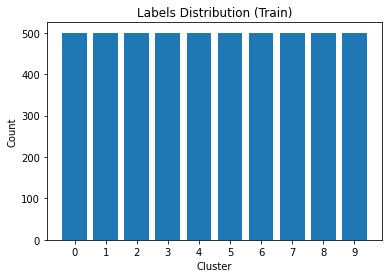

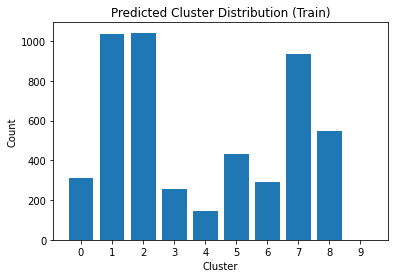

In [33]:
train_labels_predicted = gmm_seeded.predict(code_train)

plot_cluster_dist(data_train_labels, 10, "Labels Distribution (Train)")
plot_cluster_dist(train_labels_predicted, 10, "Predicted Cluster Distribution (Train)")

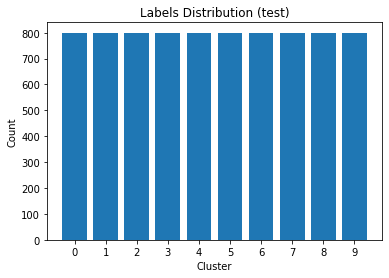

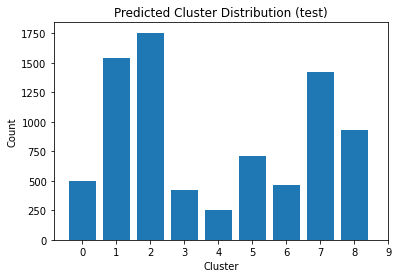

In [34]:
test_labels_predicted = gmm_seeded.predict(code_test)

plot_cluster_dist(data_test_labels, 10, "Labels Distribution (test)")
plot_cluster_dist(test_labels_predicted, 10, "Predicted Cluster Distribution (test)")

In [35]:
print(f"Accuracy (Train): {np.count_nonzero(data_train_labels == train_labels_predicted)/len(data_train_labels)*100:.2f}%")

Accuracy (Train): 25.56%


In [36]:
print(f"Accuracy (Test): {np.count_nonzero(data_test_labels == test_labels_predicted)/len(data_test_labels)*100:.2f}%")

Accuracy (Test): 25.16%


In [37]:
per_class_accuracy = get_per_class_accuracy(data_train_labels, train_labels_predicted)
print(f"Cluster Assingments (Train)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments (Train)
Cluster 0: deer, 3.40%
Cluster 1: cat, 7.60%
Cluster 2: bird, 34.60%
Cluster 3: truck, 0.00%
Cluster 4: horse, 21.20%
Cluster 5: airplane, 12.00%
Cluster 6: monkey, 43.40%
Cluster 7: ship, 43.40%
Cluster 8: car, 72.80%
Cluster 9: dog, 17.20%


In [38]:
per_class_accuracy = get_per_class_accuracy(data_test_labels, test_labels_predicted)
print(f"Cluster Assingments (Test)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments (Test)
Cluster 0: deer, 4.38%
Cluster 1: cat, 8.12%
Cluster 2: bird, 33.00%
Cluster 3: truck, 0.00%
Cluster 4: horse, 18.12%
Cluster 5: airplane, 10.75%
Cluster 6: monkey, 41.38%
Cluster 7: ship, 47.62%
Cluster 8: car, 70.25%
Cluster 9: dog, 18.00%


### Generating Samples

Text(0.5, 0.98, 'Reconstructed Sampled Data')

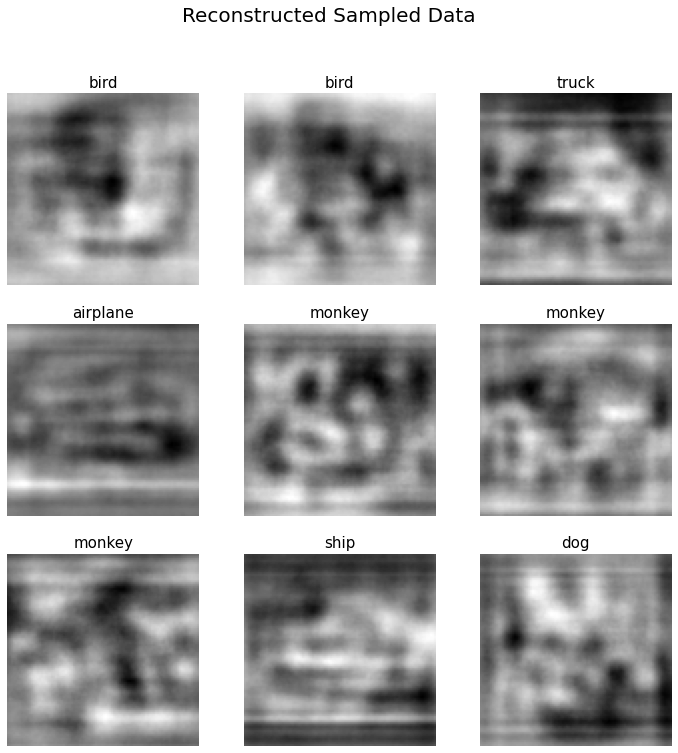

In [39]:
data_sampled, cluster = gmm.sample(9)
reconstructed_samples = pca_optimal.inverse_transform(data_sampled)

plt.figure(figsize=(12,12))
for idx, img in enumerate(reconstructed_samples):
    plt.subplot(3, 3, idx+1)
    plt.imshow(img.reshape(96,96), cmap="gray")
    plt.title(np.array(classes)[cluster_to_label[cluster[idx]]], fontsize=15)
    plt.axis('off')

plt.suptitle("Reconstructed Sampled Data", fontsize=20)
